# Defensive actions

In this notebook, we will plot defensive actions happening during one precise game. For the purpose of this study, we will take Lens vs PSG game that happened during the 2021/2022 season.

## Import packages

In [7]:
import ScraperFC as sfc
import traceback
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import numpy as np
import seaborn as sns
import pandas as pd
from mplsoccer import Pitch, add_image, FontManager, VerticalPitch, linecollection
from matplotlib.colors import to_rgba
from PIL import Image
from urllib.request import urlopen
import cmasher as cmr

## Scrape data

In [8]:
link = 'https://www.whoscored.com/Matches/1558415/Live/France-Ligue-1-2021-2022-Lens-Paris-Saint-Germain'
scraper = sfc.WhoScored()
try:
    match_data = scraper.scrape_match(link)
except:
    traceback.print_exc()
scraper.close()

## Data cleaning and framing

In [9]:
## Get home and away team id and name
home_team = match_data['matchCentreData']['home']['name']
home_id = match_data['matchCentreData']['home']['teamId']

away_team = match_data['matchCentreData']['away']['name']
away_id = match_data['matchCentreData']['away']['teamId']

# Score of the match
score = match_data['matchCentreData']['score']

# Create players dict and dataframes
home_ids = [player['playerId'] for player in match_data['matchCentreData']['home']['players']]
away_ids = [player['playerId'] for player in match_data['matchCentreData']['away']['players']]

players = match_data['matchCentreData']['playerIdNameDictionary']

df_players_home = pd.DataFrame.from_dict(match_data['matchCentreData']['home']['players'])
df_players_away = pd.DataFrame.from_dict(match_data['matchCentreData']['away']['players'])
df_players = pd.concat([df_players_home, df_players_away])

In [10]:
#Show all the rows and columns from dataframe
pd.set_option('display.max_columns', None)
#Uncomment this line if we want to see all the rows
pd.set_option("max_rows", None) 

df = pd.DataFrame.from_dict(match_data['matchCentreData']['events'])

df_period = pd.json_normalize(df['period'])
df['period'] = df_period['displayName']

df_type = pd.json_normalize(df['type'])
df['type'] = df_type['displayName']

df_outcomeType = pd.json_normalize(df['outcomeType'])
df['outcomeType'] = df_outcomeType['displayName']

#Change teamId to team name
df['teamId'] = df['teamId'].apply(lambda x: home_team if x == home_id else away_team)

### Filter out the columns with only relevant data and add player name, shirt No to df
df_rel = df[['id','eventId','minute','second','teamId','x', 'y', 'period', 'type', 'outcomeType', 'playerId', 'endX', 'endY']]
df_rel = df_rel.merge(df_players[['playerId', 'shirtNo', 'name']], how='left')

### Create a column passer and recipient that will be used when we filter by passes
df_rel['passer'] = df_rel['shirtNo']
df_rel['recipient'] = df_rel['shirtNo'].shift(-1)

df_home = df_rel[df_rel['teamId'] == home_team]
df_away = df_rel[df_rel['teamId'] == away_team]

We print out below all the unique values encountered in the dataframe. This will allow us to select what are the defensive actions that we will filter out for the plotting. 

In [11]:
df_rel['type'].unique()

array(['Start', 'Pass', 'BallRecovery', 'Foul', 'BallTouch',
       'ShieldBallOpp', 'Interception', 'Challenge', 'TakeOn',
       'Dispossessed', 'Tackle', 'BlockedPass', 'MissedShots',
       'SavedShot', 'Save', 'CornerAwarded', 'KeeperPickup', 'Aerial',
       'ShotOnPost', 'Clearance', 'OffsideGiven', 'OffsidePass',
       'OffsideProvoked', 'End', 'FormationChange', 'Card', 'Claim',
       'SubstitutionOff', 'SubstitutionOn', 'Error', 'Goal',
       'FormationSet'], dtype=object)

In [12]:
def_actions = ['BallRecovery', 'Foul', 'Interception', 'Tackle', 'Clearance', 'BlockedPass']
def_actions_series = df_rel.type.isin(def_actions)
df_def_actions = df_rel[def_actions_series]
df_def_home = df_def_actions.loc[df_def_actions.teamId == home_team]
df_def_away = df_def_actions.loc[df_def_actions.teamId == away_team]

## Visualisation

We will visualize below the defensive actions on the pitch. I decided to also plot a kde plot to see in which parts of the field defensive actions are concentrated. 

Text(1, 1, 'Created by @Stevojms')

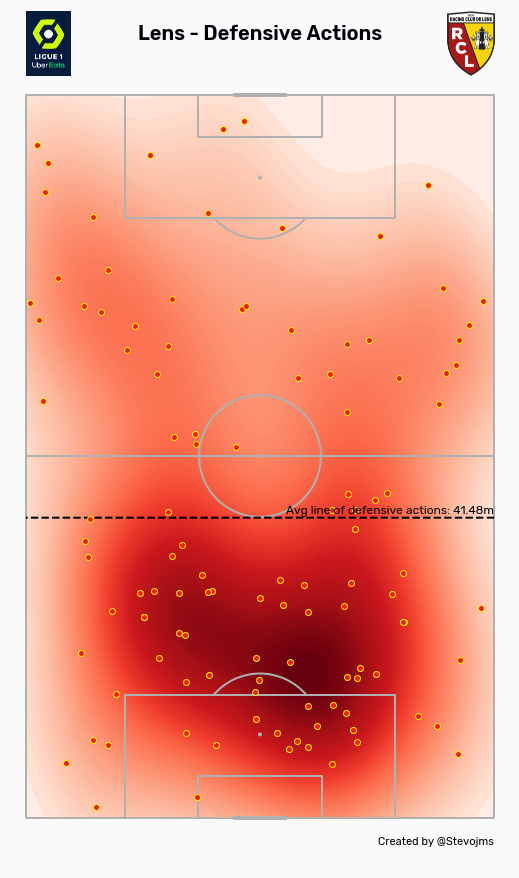

In [26]:
#Pitch visualisation home team

team_color = '#ec1c24' #Fill in the team color
node_edgecolor = '#fff200'
number_color = '#ffffff'

bgcol = '#fafafa' 

URL = 'https://github.com/googlefonts/rubik/blob/main/fonts/ttf/Rubik-Light.ttf?raw=true'
URL2 = 'https://github.com/googlefonts/rubik/blob/main/fonts/ttf/Rubik-Regular.ttf?raw=true'
URL3 = 'https://github.com/googlefonts/rubik/blob/main/fonts/ttf/Rubik-SemiBold.ttf?raw=true'

rubik_light = FontManager(URL)
rubik_regular = FontManager(URL2)
rubik_semibold = FontManager(URL3)

#Change image URL if needed
COMPETITION_URL = 'https://upload.wikimedia.org/wikipedia/commons/4/49/Ligue1_Uber_Eats_logo.png'
competition_image = Image.open(urlopen(COMPETITION_URL))

#Change team logo URL if needed
team_logo_URL = 'https://www.rclens.fr/sites/default/files/lens.png' #Team logo
team_logo_image = Image.open(urlopen(team_logo_URL))

pitch = VerticalPitch(pitch_type= 'opta', half=False)
fig, axs = pitch.grid(figheight=12, title_height=0.08, endnote_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      title_space=0, grid_height=0.88, endnote_height=0.04)

fig.set_facecolor(bgcol)
axs['title'].set_facecolor(bgcol)
axs['pitch'].set_facecolor(bgcol)
axs['endnote'].set_facecolor(bgcol)

def_nodes = pitch.scatter(df_def_home.x, df_def_home.y, c=team_color, edgecolors=node_edgecolor, ax=axs['pitch'], zorder = 3)
kdeplot = pitch.kdeplot(df_def_home.x, df_def_home.y, cmap = 'Reds', ax=axs['pitch'], shade = True, levels = 100, shade_lowest=True, cut = 20, zorder = 0)
avg_def_line = linecollection.lines(df_def_home.x.mean(), 0, df_def_home.x.mean(), 100, ls = '--', lw = 2, color = 'black', vertical = True, ax=axs['pitch'],  zorder=1)

pitch.annotate(f'Avg line of defensive actions: {round(df_def_home.x.mean(), 2)}m', xy=(df_def_home.x.mean()+1,0),
               va="center", ha="right",
               size = 12, ax=axs['pitch'], fontproperties=rubik_regular.prop, zorder = 3)

TITLE = f'{home_team} - Defensive Actions'
#SUB_TITLE = f'Until 1st substitution ({subs_home[0]} min) – {home_team} {score} {away_team}'
axs['title'].text(0.5, 0.6, TITLE, color='#000009',
                  va='center', ha='center', fontproperties=rubik_semibold.prop, fontsize=20)
#axs['title'].text(0.5, 0.30, SUB_TITLE, color='#000009',
                  #va='center', ha='center', fontproperties=rubik_regular.prop, fontsize=16)

ax_competition = add_image(competition_image, fig,
                     # set the left, bottom and height to align with the title
                     left=axs['title'].get_position().x0,
                     bottom=axs['title'].get_position().y0,
                     height=axs['title'].get_position().height-0.005)

ax_team_logo = add_image(team_logo_image, fig,
                     # set the left to align with the pitch left border
                     left=0.85,
                     bottom=axs['title'].get_position().y0,
                     height=axs['title'].get_position().height-0.005)

ENDNOTE_LEFT = 'Created by @Stevojms'
#ENDNOTE_RIGHT1 = f'Node position : average start location of completed passes\nMinimum number of passes : {min_nb_passes_home}'

axs['endnote'].text(1, 1, ENDNOTE_LEFT,
                  va='top', ha='right', fontproperties=rubik_regular.prop, fontsize=11)
#axs['endnote'].text(0, 1, ENDNOTE_RIGHT1,
                  #va='top', ha='left', fontproperties=rubik_regular.prop, fontsize=11)


Text(0, 1, 'Defensive actions : Ball recoveries, fouls, interceptions\ntackles, clearances, blocked passes')

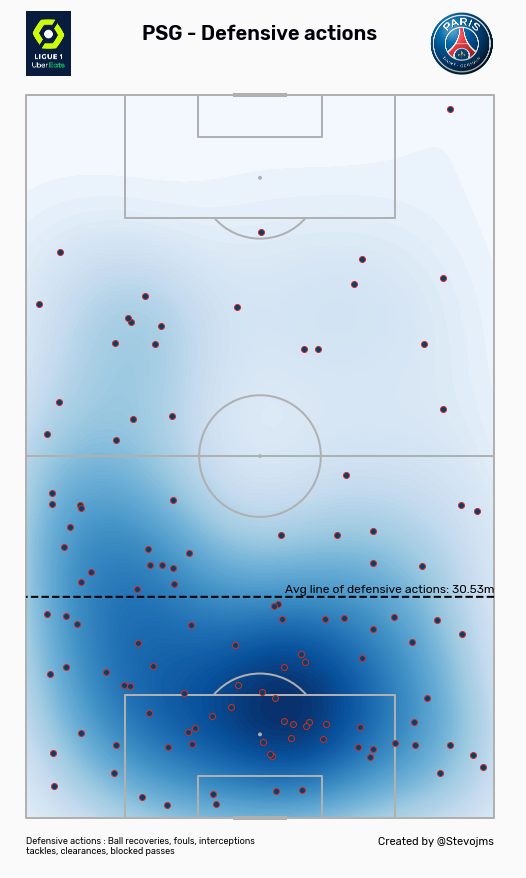

In [23]:
#Pitch visualisation

team_color = '#004170' #Fill in the team color
node_edgecolor = '#DA291C'
number_color = '#ffffff'

bgcol = '#fafafa' 

URL = 'https://github.com/googlefonts/rubik/blob/main/fonts/ttf/Rubik-Light.ttf?raw=true'
URL2 = 'https://github.com/googlefonts/rubik/blob/main/fonts/ttf/Rubik-Regular.ttf?raw=true'
URL3 = 'https://github.com/googlefonts/rubik/blob/main/fonts/ttf/Rubik-SemiBold.ttf?raw=true'

rubik_light = FontManager(URL)
rubik_regular = FontManager(URL2)
rubik_semibold = FontManager(URL3)

#Change image URL if needed
COMPETITION_URL = 'https://upload.wikimedia.org/wikipedia/commons/4/49/Ligue1_Uber_Eats_logo.png'
competition_image = Image.open(urlopen(COMPETITION_URL))

#Change team logo URL if needed
team_logo_URL = 'https://logos-world.net/wp-content/uploads/2020/06/PSG-Logo.png' #Team logo
team_logo_image = Image.open(urlopen(team_logo_URL))

pitch = VerticalPitch(pitch_type= 'opta', half=False)
fig, axs = pitch.grid(figheight=12, title_height=0.08, endnote_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      title_space=0, grid_height=0.88, endnote_height=0.04)

fig.set_facecolor(bgcol)
axs['title'].set_facecolor(bgcol)
axs['pitch'].set_facecolor(bgcol)
axs['endnote'].set_facecolor(bgcol)

#pass_arrows = pitch.arrows(pass_between.x, pass_between.y, pass_between.x_end, pass_between.y_end, lw=pass_between.width, color=color, zorder=2, ax=axs['pitch'])

def_nodes = pitch.scatter(df_def_away.x, df_def_away.y, c=team_color, edgecolors=node_edgecolor, ax=axs['pitch'], zorder = 3)
kdeplot = pitch.kdeplot(df_def_away.x, df_def_away.y, cmap = 'Blues', ax=axs['pitch'], shade = True, levels = 100, shade_lowest=True, zorder = 0)
avg_def_line = linecollection.lines(df_def_away.x.mean(), 0, df_def_away.x.mean(), 100, ls = '--', lw = 2, color = 'black', vertical = True, ax=axs['pitch'],  zorder=1)

pitch.annotate(f'Avg line of defensive actions: {round(df_def_away.x.mean(), 2)}m', xy=(df_def_away.x.mean()+1,0),
               va="center", ha="right",
               size = 12, ax=axs['pitch'], fontproperties=rubik_regular.prop, zorder = 2)

TITLE = f'{away_team} - Defensive actions'
#SUB_TITLE = f'Until 1st substitution ({subs_away[0]} min) - {home_team} {score} {away_team}'
axs['title'].text(0.5, 0.6, TITLE, color='#000009',
                  va='center', ha='center', fontproperties=rubik_semibold.prop, fontsize=20)
#axs['title'].text(0.5, 0.30, SUB_TITLE, color='#000009',
                  #va='center', ha='center', fontproperties=rubik_regular.prop, fontsize=16)

    
ax_competition = add_image(competition_image, fig,
                     # set the left, bottom and height to align with the title
                     left=axs['title'].get_position().x0,
                     bottom=axs['title'].get_position().y0,
                     height=axs['title'].get_position().height-0.005)

ax_team_logo = add_image(team_logo_image, fig,
                     # set the left to align with the pitch left border
                     left=0.77,
                     bottom=axs['title'].get_position().y0,
                     height=axs['title'].get_position().height-0.005)

ENDNOTE_LEFT = 'Created by @Stevojms'
ENDNOTE_RIGHT1 = 'Defensive actions : Ball recoveries, fouls, interceptions\ntackles, clearances, blocked passes'

axs['endnote'].text(1, 1, ENDNOTE_LEFT,
                  va='top', ha='right', fontproperties=rubik_regular.prop, fontsize=11)
axs['endnote'].text(0, 1, ENDNOTE_RIGHT1,
                  va='top', ha='left', fontproperties=rubik_regular.prop, fontsize=9)
